# Project: Predicting the Winner of League of Legends Games

Dataset Source: https://www.kaggle.com/datasets/datasnaek/league-of-legends
Instructions: 
1. Download the dataset from the above link.
2. Place the 'games.csv' file in the same directory as this notebook.

# Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the dataset

In [6]:
# We are loading the dataset into a pandas DataFrame for further analysis.
df = pd.read_csv('games.csv')

In [7]:
# Load the champion data for later use in mapping champion IDs to their names
# This is a JSON file that contains metadata about champions.
champ_data = json.load(open('champion_info.json'))

# Preview the dataset

In [9]:
# Displaying the first few rows of the dataset to understand its structure and contents.
df.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


In [10]:
# Checking the structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51490 entries, 0 to 51489
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gameId              51490 non-null  int64
 1   creationTime        51490 non-null  int64
 2   gameDuration        51490 non-null  int64
 3   seasonId            51490 non-null  int64
 4   winner              51490 non-null  int64
 5   firstBlood          51490 non-null  int64
 6   firstTower          51490 non-null  int64
 7   firstInhibitor      51490 non-null  int64
 8   firstBaron          51490 non-null  int64
 9   firstDragon         51490 non-null  int64
 10  firstRiftHerald     51490 non-null  int64
 11  t1_champ1id         51490 non-null  int64
 12  t1_champ1_sum1      51490 non-null  int64
 13  t1_champ1_sum2      51490 non-null  int64
 14  t1_champ2id         51490 non-null  int64
 15  t1_champ2_sum1      51490 non-null  int64
 16  t1_champ2_sum2      51490 non-null  int6

# Data Cleaning

In [12]:
# Checking for any duplicate rows and removing them
df = df.drop_duplicates()

In [13]:
# Checking for missing values
df.isnull().sum()

gameId          0
creationTime    0
gameDuration    0
seasonId        0
winner          0
               ..
t2_ban1         0
t2_ban2         0
t2_ban3         0
t2_ban4         0
t2_ban5         0
Length: 61, dtype: int64

# Data Transformation (Mapping Champion IDs to Champion Names)

In [15]:
# Map champion IDs to champion names for both teams
# Each team has 5 champions represented by IDs. We map these IDs to their names using the JSON data.
df.loc[:, 't1_champ1'] = df['t1_champ1id'].apply(lambda x: champ_data['data'][str(x)]['name'])
df.loc[:, 't1_champ2'] = df['t1_champ2id'].apply(lambda x: champ_data['data'][str(x)]['name'])
df.loc[:, 't1_champ3'] = df['t1_champ3id'].apply(lambda x: champ_data['data'][str(x)]['name'])
df.loc[:, 't1_champ4'] = df['t1_champ4id'].apply(lambda x: champ_data['data'][str(x)]['name'])
df.loc[:, 't1_champ5'] = df['t1_champ5id'].apply(lambda x: champ_data['data'][str(x)]['name'])

df.loc[:, 't2_champ1'] = df['t2_champ1id'].apply(lambda x: champ_data['data'][str(x)]['name'])
df.loc[:, 't2_champ2'] = df['t2_champ2id'].apply(lambda x: champ_data['data'][str(x)]['name'])
df.loc[:, 't2_champ3'] = df['t2_champ3id'].apply(lambda x: champ_data['data'][str(x)]['name'])
df.loc[:, 't2_champ4'] = df['t2_champ4id'].apply(lambda x: champ_data['data'][str(x)]['name'])
df.loc[:, 't2_champ5'] = df['t2_champ5id'].apply(lambda x: champ_data['data'][str(x)]['name'])

# Preview the updated dataset to ensure that champion names have been mapped correctly
df.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t1_champ1,t1_champ2,t1_champ3,t1_champ4,t1_champ5,t2_champ1,t2_champ2,t2_champ3,t2_champ4,t2_champ5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,Vladimir,Bard,Kog'Maw,Master Yi,Viktor,Graves,Xayah,Darius,Zed,Thresh
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,Draven,Irelia,Nidalee,Kayle,Shaco,Malphite,Morgana,Hecarim,Yasuo,Riven
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,Tristana,Kayn,Nami,Rumble,Kassadin,Cassiopeia,Thresh,Jayce,Jax,Ashe
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,Maokai,Brand,Twitch,Orianna,Dr. Mundo,Malzahar,Warwick,Thresh,Riven,Ashe
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,Warwick,Twitch,Janna,Draven,Syndra,Sona,Jarvan IV,Kayn,Kassadin,Caitlyn


# Data Selection

In [17]:
# Select relevant features for our model
# We choose only the columns representing champion selections, game objectives, and the final winner.
df = df[['t1_champ1', 't1_champ2', 't1_champ3', 't1_champ4', 't1_champ5', 
         't2_champ1', 't2_champ2', 't2_champ3', 't2_champ4', 't2_champ5', 
         'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 
         'firstRiftHerald', 'winner']]

# One-Hot Encoding and Data Transformation

In [19]:
# One-hot encode the champion selections for both teams
# This step converts categorical champion names into binary features. 
encodings1 = [pd.get_dummies(df[col], prefix='t1') for col in ['t1_champ1', 't1_champ2', 't1_champ3', 't1_champ4', 't1_champ5']]
combined_df1 = sum(encodings1)

encodings2 = [pd.get_dummies(df[col], prefix='t2') for col in ['t2_champ1', 't2_champ2', 't2_champ3', 't2_champ4', 't2_champ5']]
combined_df2 = sum(encodings2)

In [20]:
# Combine the one-hot encoded columns with the original dataframe
df = df.join(combined_df1).join(combined_df2)

In [21]:
# Drop the original categorical champion columns as they have been transformed
df = df.drop(['t1_champ1', 't1_champ2', 't1_champ3', 't1_champ4', 't1_champ5',
              't2_champ1', 't2_champ2', 't2_champ3', 't2_champ4', 't2_champ5'], axis=1)

# Data Splitting

In [23]:
# Splitting the data into features (X) and target (y)
# We will predict the 'winner' column using the other features as predictors.
X, y = df.drop('winner', axis=1), df['winner']

In [24]:
# This step splits the dataset into training and testing sets (70% train, 30% test) to evaluate model performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter Tuning

In [27]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [29]:
# Define the RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1)

In [33]:
# Perform grid search
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [48]:
# Get the best model from GridSearchCV
best_rfc = grid_search.best_estimator_

In [35]:
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}


# Cross-Validation

In [50]:
# Evaluate the model's robustness across different splits of the data.
cv_scores = cross_val_score(best_rfc, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Average CV score: {cv_scores.mean()}")

Cross-validation scores: [0.89844286 0.89697385 0.89942219 0.8927522  0.89784525]
Average CV score: 0.8970872705406615


# Model Training

In [52]:
# Fit the best model on the training data
best_rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=200, n_jobs=-1)

# Model Evaluation and Performance Metrics

In [54]:
# Evaluate the model on the test set to check its accuracy in predicting game outcomes.
accuracy = best_rfc.score(X_test, y_test)
print(f"Tuned Random Forest Accuracy: {accuracy * 100:.2f}%")

Tuned Random Forest Accuracy: 89.60%


In [55]:
# Evaluating the model using additional performance metrics like precision, recall, and F1 score.
# classification_report gives a detailed breakdown of these metrics.
y_pred = best_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.89      0.91      0.90      7792
           2       0.90      0.88      0.89      7524

    accuracy                           0.90     15316
   macro avg       0.90      0.90      0.90     15316
weighted avg       0.90      0.90      0.90     15316



In [56]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

In [57]:
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[7082  710]
 [ 883 6641]]


# Feature Importance Analysis
Analyze which features (e.g., champion picks, game objectives) are most important for the model’s predictions.

In [59]:
# Feature Importance Analysis (Top )
feature_importances = pd.Series(best_rfc.feature_importances_, index=X.columns)

In [60]:
# Sort the features by importance and select the top 10
top_features = feature_importances.sort_values(ascending=False).head(10)

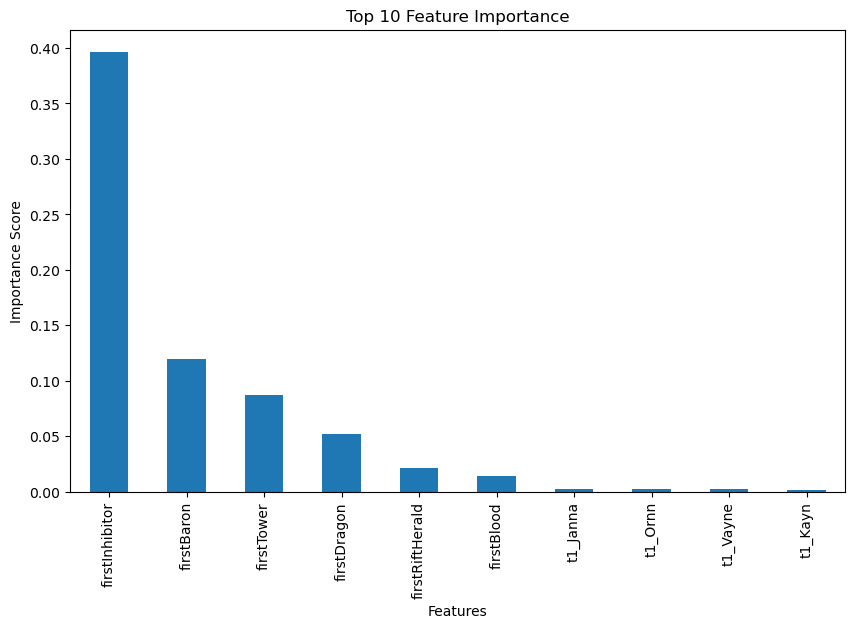

In [61]:
# Plot the top 10 features
top_features.plot(kind='bar', figsize=(10,6))
plt.title('Top 10 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

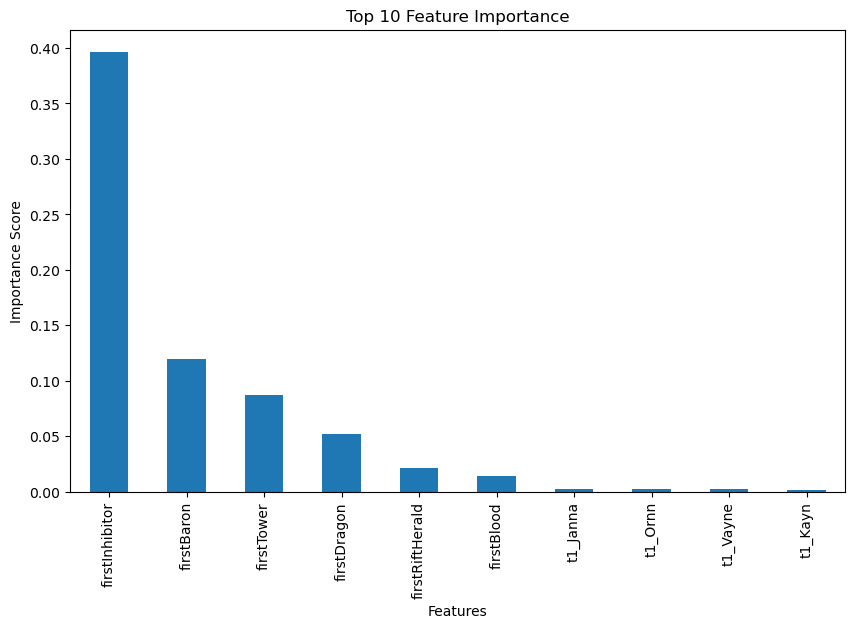

In [62]:
# Plot the top 10 features
top_features.plot(kind='bar', figsize=(10,6))
plt.title('Top 10 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()